In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Import data


In [4]:
test = pd.read_csv('data/test.csv')
shop = pd.read_csv('data/shops.csv')
submission = pd.read_csv('data/sample_submission.csv')
sales = pd.read_csv('data/sales_train.csv')
items = pd.read_csv('data/items.csv')
item_category = pd.read_csv('data/item_categories.csv')

# Aggregate data
Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation. 

In [5]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Exploratory Data Analysis

There is 60 unique shop_id

In [6]:
shop.head(5)
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

There is 60 unique item_category_id.

In [7]:
item_category.head(5)
item_category.describe()
item_category.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

There is 22170 unique item_id.

In [8]:
items.head(5)
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

Review the format for submission.

In [9]:
test.head(5)
submission.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Finally, the main dataset for training data. 

In [10]:
sales.head(5)
sales.describe()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


# Plot of date_block_num against index. 

The distribution of each date_block_num is balanced. 

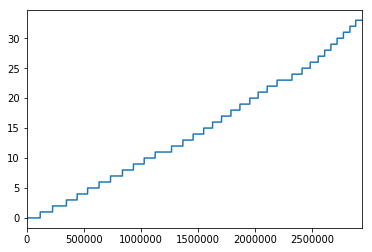

In [11]:
sales.date_block_num.plot()

# Plot of shop_id against item_id on train and test data

Train data consists of sales/returns only, while test data was constructed as a cartesian product of all shops and items in the given month (shops * items) - so it will include a lot of "non-sales" occurrences

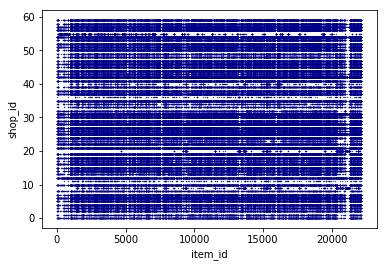

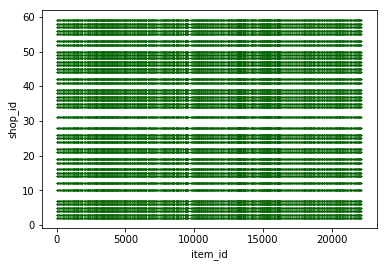

In [12]:
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)



We can see that after merging sales data on test data, there is about 50% of missing values.

In [13]:
test.merge(sales, how='left', on=['shop_id', 'item_id']).isnull().sum()

test.shape[0]

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

Identify outliers in sales data. We found that there are some high price sales such as Radmin 3: Reliable Remote Support Software which more than USD 3468 or 200000 Russian Ruble.

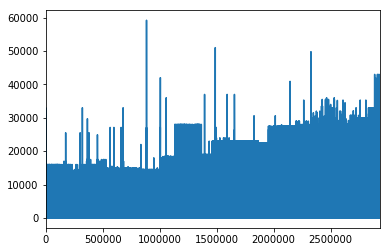

In [43]:
sales.item_price.plot()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


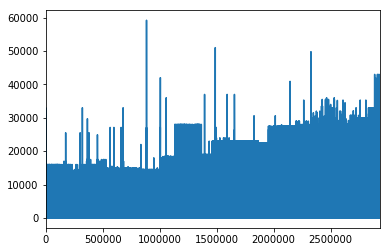

In [45]:
sales.item_price.plot()
sales[sales['item_price'] > 100000]
items[items['item_id'] == 6066]

For number of sales, there is an amount of sales more than 900. They are some kind of plastic bags and delivery services.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


,item_name,item_id,item_category_id


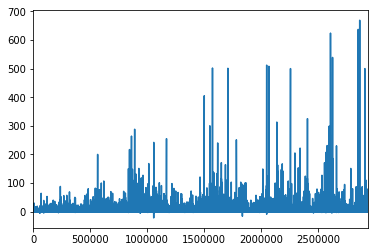

In [48]:
sales.item_cnt_day.plot()
sales[sales['item_cnt_day'] > 900]
items[(items['item_id'] == 11373) & (items['item_id'] == 20949)]

Outliers above are removed so we only include item price that less than 100000 and amount of sales that less or equal to 900.

In [16]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [17]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')
sales_m = pd.merge(sales_m,item_category, on=['item_category_id'], how='left')

# Mean encoding

We perform mean encoding on all category data which are item_id, shop_id and item_category_id

In [18]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

We append test data into train data so we can create lag features on them.

In [19]:
temp_test = test.copy()
temp_test['date_block_num'] = 34
temp_test.drop('ID', axis=1, inplace=True)

temp_test = temp_test.merge(items, how='left', on='item_id')
temp_test = temp_test.merge(item_category, how='left', on='item_category_id')
temp_test.drop('item_name', axis=1, inplace=True)

In [20]:
sales_m.drop('item_name', axis=1, inplace=True)
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True)


We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram. 

In [32]:
lag_variables  = ['item_id_avg_item_price',
'item_id_sum_item_cnt_day',
'item_id_avg_item_cnt_day',
'shop_id_avg_item_price',
'shop_id_sum_item_cnt_day',
'shop_id_avg_item_cnt_day',
'item_category_id_avg_item_price',
'item_category_id_sum_item_cnt_day',
'item_category_id_avg_item_cnt_day',
'item_cnt_day']

#Limited by computation resource
lags = [1,2,3,4]
#lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [33]:
sales_m.describe()

,date_block_num,item_category_id,item_category_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_cnt_day,item_id,item_id_avg_item_cnt_day,item_id_avg_item_price,item_id_sum_item_cnt_day,...,item_id_avg_item_price_lag_4,item_id_sum_item_cnt_day_lag_4,item_id_avg_item_cnt_day_lag_4,shop_id_avg_item_price_lag_4,shop_id_sum_item_cnt_day_lag_4,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4
count,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,6.291948e+06,...,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06,3.428059e+06
mean,2.254882e+01,4.497995e+01,3.123683e-01,1.257896e+02,5.566926e+03,3.123683e-01,1.125913e+04,3.123683e-01,1.251594e+02,1.494542e+01,...,1.691311e+02,2.173579e+01,4.489747e-01,1.264493e+02,2.077766e+03,3.275551e-01,1.366338e+02,6.097258e+03,3.590698e-01,4.534505e-01
std,6.183325e+00,1.578376e+01,1.625811e+00,3.692584e+02,5.564782e+03,3.443805e+00,6.275296e+03,1.943069e+00,5.011363e+02,9.418217e+01,...,5.914551e+02,1.189953e+02,2.437708e+00,6.333960e+01,1.699548e+03,2.639786e-01,4.029990e+02,5.614745e+03,2.038839e+00,3.961569e+00
min,1.300000e+01,0.000000e+00,-2.272727e-02,2.600000e-01,-1.000000e+00,-5.000000e+00,0.000000e+00,-3.913043e-01,1.000000e-02,-1.800000e+01,...,2.600000e-01,-1.800000e+01,-3.913043e-01,2.329451e-02,2.000000e+00,3.025261e-04,2.600000e-01,1.000000e+00,1.041667e-02,-2.000000e+00
25%,1.700000e+01,3.700000e+01,1.382500e-01,3.169897e+01,8.010000e+02,0.000000e+00,5.675000e+03,2.325581e-02,9.576923e+00,1.000000e+00,...,1.596000e+01,3.000000e+00,6.000000e-02,8.744218e+01,1.117000e+03,1.818719e-01,3.272667e+01,9.780000e+02,1.530612e-01,0.000000e+00
50%,2.200000e+01,4.000000e+01,2.129303e-01,4.632971e+01,3.756000e+03,0.000000e+00,1.137000e+04,8.000000e-02,2.706250e+01,4.000000e+00,...,4.103922e+01,7.000000e+00,1.428571e-01,1.112884e+02,1.558000e+03,2.490869e-01,4.673057e+01,5.064000e+03,2.227471e-01,0.000000e+00
75%,2.700000e+01,5.600000e+01,2.672145e-01,1.215649e+02,9.291000e+03,0.000000e+00,1.653300e+04,2.272727e-01,8.142857e+01,1.100000e+01,...,1.258743e+02,1.700000e+01,3.478261e-01,1.515399e+02,2.144000e+03,3.348707e-01,1.376564e+02,9.714000e+03,2.917460e-01,0.000000e+00
max,3.400000e+01,8.300000e+01,2.437000e+02,2.197885e+04,2.126600e+04,1.644000e+03,2.216900e+04,2.437000e+02,2.408645e+04,1.218500e+04,...,2.408645e+04,1.218500e+04,2.437000e+02,4.420703e+02,1.461000e+04,2.211961e+00,2.197885e+04,2.126600e+04,2.437000e+02,1.209000e+03


Fill missing values

In [34]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

# Feature we tried but not improving the score
We tried generating text feature on item_category_name by TF-IDF. It slows down the training and still not giving good result in leaderboard. We run through grid search for optimizing the hyperparameters and it takes more than 2 days with i7-7700 and 64GB ram. Due to the limited time of accessing the higher spec computer, we give up this feature.

In [35]:
# sales_m['item_category_name'] = sales_m.item_category_name.str.replace(' - ', ' ')

# count_vect = CountVectorizer(ngram_range=(1, 2), min_df=0.1)

#Tfidf for item_category_name
# X_train_counts = count_vect.fit_transform(sales_m.item_category_name)
# tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
# X_train_tf = tf_transformer.transform(X_train_counts)

# header = ['cate_fea_' + str(i) for i in range(0, X_train_tf.toarray().shape[1])]
# text_fea = pd.DataFrame(X_train_tf.toarray(),  columns=header)
# sales_m = sales_m.join(text_fea)

Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.

In [36]:
cols_to_drop = lag_variables[:-1] + ['item_price']
sales_m = sales_m[sales_m['date_block_num']>12]

# Validation

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing. 

In [40]:
X_train = sales_m[sales_m['date_block_num']<33].drop(cols_to_drop, axis=1)
X_cv =  sales_m[sales_m['date_block_num']==33].drop(cols_to_drop, axis=1)
X_test = sales_m[sales_m['date_block_num']==34].drop(cols_to_drop, axis=1)

# Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [41]:
X_train['item_cnt_day'] = X_train['item_cnt_day'].clip_upper(40)
X_train['item_cnt_day'] = X_train['item_cnt_day'].clip_lower(0)

X_cv['item_cnt_day'] = X_cv['item_cnt_day'].clip_upper(40)
X_cv['item_cnt_day'] = X_cv['item_cnt_day'].clip_lower(0)

X_test['item_cnt_day'] = X_test['item_cnt_day'].clip_upper(40)
X_test['item_cnt_day'] = X_test['item_cnt_day'].clip_lower(0)

In [42]:
X_train.to_csv('X_train.csv', index=False)
X_cv.to_csv('X_cv.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
